## Install the required libraries

In [1]:
!pip install sounddevice
!pip install resampy
!pip install pathlib


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for resampy from https://files.pythonhosted.org/packages/4d/b9/3b00ac340a1aab3389ebcc52c779914a44aadf7b0cb7a3bf053195735607/resampy-0.4.3-py3-none-any.whl.metadata
   ---------------------------------------- 3.1/3.1 MB 17.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import the required libraries

In [2]:
import numpy as np
import sounddevice as sd
import scipy.signal as sg
import matplotlib.pyplot as plt
import resampy
from pathlib import Path

## Setting sweep parameters
- $F_s$ is the sampling frequency
- $f_1$ is the starting frequency
- $f_2$ is the ending frequency
- $T$ is the sampling duration
- $N$ is the number of samples
- $R = \ln{\frac{f_2}{f_1}}$

In [3]:
Fs = 48000
f1 = 100
f2 = 22000
T = 8
N = int(Fs * T)
R = np.log(f2 / f1)
n = np.arange(N)

## Sweep generation
- Generate the exponential sweep using $s[n]=\sin\bigg(\frac{2\pi f_1 T}{R}\bigg(\exp{\bigg(\frac{nR}{N}\bigg)}-1\bigg)\bigg)$

In [4]:
sweep = np.sin(2*np.pi*f1*T/R * (np.exp(n*R/N) - 1))
sweep *= sg.tukey(N, 0.04)    
sweep *= 10**(-3/20)
barker = (np.array([1,1,1,1,1,0,0,1,1,0,1,0,1])*2-1).repeat(300)*0.7

## Record the probe

In [5]:
rec_len = int(1.1 * (13*300 + 2*8*Fs))   # ≈ 19 s
recording = sd.rec(rec_len, samplerate=Fs, channels=1)
sd.wait()
y = recording[:,0].astype(np.float32)

## Define a cross-correlation peak-locating function using FFT

In [6]:
def corr_peak(sig, ref):
    Nfft = 2**int(np.ceil(np.log2(len(sig)+len(ref))))
    corr = np.fft.irfft(np.fft.rfft(sig[::-1],Nfft)*np.fft.rfft(ref,Nfft))
    return np.argmax(np.abs(corr))

## Locate and remove the barker

In [7]:
p_barker = corr_peak(y, barker)
y_trim   = y[p_barker + len(barker):]

## Locate the two cross-correlation peaks and estimate the SRO

In [8]:
p1 = corr_peak(y_trim, sweep)
p2 = corr_peak(y_trim[p1 + N//2:], sweep) + p1 + N//2
eps_hat = (p2 - p1 - N)/N
print(f"SRO ε̂ = {eps_hat*1e6:.1f} ppm")

SRO ε̂ = -344143.2 ppm


## Resample the received signal, with the $\hat{\epsilon}$ estimated above

In [9]:
y_rs = resampy.resample(y_trim, 1+eps_hat, 1, axis=0)

## Compute the final cross-correlation peak location, using the resampled received signal and the probe, then adjust the shift

In [10]:
n0 = corr_peak(y_rs, sweep)
sweep_rx = y_rs[n0 : n0 + N]

## Construct the inverse filter

In [11]:
inv = sweep[::-1] * np.exp(-n[::-1]*R/N) 

## Regularised de-convolution

In [12]:
pad   = 2**int(np.ceil(np.log2(len(sweep_rx))))
Hhat  = np.fft.irfft(np.fft.rfft(sweep_rx, pad) * np.fft.rfft(inv, pad))
Lh    = 4096                                         
rir   = Hhat[:Lh] * sg.tukey(Lh, 0.1)

## Plot and save for OFDM equaliser

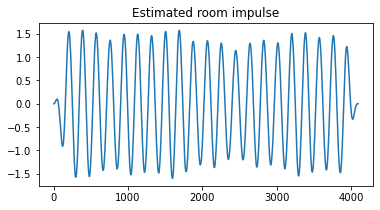

Saved 32-bit float RIR to rir.npy


In [13]:
plt.figure(figsize=(6,3)) 
plt.plot(rir)
plt.title("Estimated room impulse")
plt.show()
Path("rir.npy").write_bytes(rir.astype(np.float32).tobytes())
print("Saved 32-bit float RIR to rir.npy")